In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
sns.set_theme()

In [2]:
lotus = pd.read_csv("../data/230106_frozen_metadata.csv.gz", low_memory=False)
lotus = lotus.rename(columns={'organism_name': 'species', 'structure_smiles_2D': 'molecule'})

In [3]:
directory = '../out/'
dataframes = []  # List to hold dataframes
for filename in os.listdir(directory):
    if filename.endswith('.parquet'):  # Ensures only parquet files are read
        filepath = os.path.join(directory, filename)
        df = pd.read_parquet(filepath)  # Read parquet file to a pandas df
        dataframes.append(df)  # Append the df to the list
df = pd.concat(dataframes, ignore_index=True)

df.prob = df.prob.astype('float32')

In [4]:
pivot_df = df.pivot_table(index='species', columns='molecule', values='prob')
del df

In [5]:
pivot_df

molecule,B,Br,BrC(Br)(Br)Br,BrC(Br)(Br)CCCCC1CO1,BrC(Br)=CC(Br)Br,BrC(Br)Br,BrC(Br)I,BrC(I)=CC(Br)Br,BrC(I)I,BrCBr,...,c1cnccn1,c1cncnc1,c1cnoc1,c1coc(CCn2cccc2)c1,c1coc(CNc2nc[nH]c3ncnc2-3)c1,c1csc(-c2ccc(-c3cccs3)s2)c1,c1csc(-c2ccsc2-c2cccs2)c1,c1csc(C2CC2)c1,c1ncc2c(n1)NCCN2,c1ncc2nc[nH]c2n1
species,,,,,,,,,,,,,,,,,,,,,
Aepyceros melampus,0.178596,0.007703,0.010242,0.006943,0.007793,0.271368,0.005911,0.010512,0.003638,0.129686,...,0.603532,0.660622,0.063163,0.011492,0.854188,0.120599,0.017896,0.024536,0.485028,0.713338
Alternaria jesenskae,0.004626,0.007736,0.059711,0.061322,0.092249,0.264152,0.051929,0.082266,0.053825,0.199305,...,0.312056,0.159845,0.019730,0.000726,0.136174,0.010426,0.001312,0.001756,0.049072,0.188639
Aplidium uouo,0.003197,0.013365,0.084615,0.044527,0.045537,0.396596,0.062703,0.042338,0.100948,0.326722,...,0.040081,0.245225,0.002065,0.000034,0.035120,0.021337,0.000265,0.000430,0.232451,0.169627
Arabidopsis thaliana,0.775139,0.473739,0.155668,0.124041,0.097252,0.696573,0.152891,0.088249,0.082173,0.606039,...,0.841210,0.981179,0.523365,0.169468,0.971306,0.433989,0.043919,0.666044,0.782237,0.891638
Arnica amplexicaulis,0.013038,0.000257,0.001997,0.004816,0.001940,0.050765,0.002054,0.001783,0.002367,0.018803,...,0.569779,0.365133,0.003869,0.025870,0.805593,0.806217,0.782193,0.047739,0.029120,0.238311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sulfolobus shibatae,0.000598,0.001993,0.007552,0.004367,0.003879,0.089107,0.004627,0.004232,0.006193,0.120566,...,0.020953,0.131184,0.000161,0.000007,0.040427,0.000169,0.000027,0.000283,0.042763,0.115566
Thermoplasma acidophilum,0.144290,0.196832,0.286891,0.158282,0.174853,0.493512,0.224926,0.193641,0.188475,0.332827,...,0.237402,0.683574,0.012549,0.004096,0.247548,0.097507,0.013527,0.028184,0.852989,0.634740
Thorecta reticulata,0.006658,0.003302,0.001298,0.001693,0.001138,0.045443,0.000925,0.000653,0.000986,0.010359,...,0.122366,0.102948,0.019558,0.000134,0.254589,0.031610,0.001216,0.000295,0.047055,0.093571


In [6]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [7]:
# Standardize the data (important for PCA)
scaler = StandardScaler()
species_std = scaler.fit_transform(pivot_df)

In [8]:
# Initialize PCA
pca = KernelPCA(n_components=2, kernel='cosine')

# Fit and transform the data
pca_result = pca.fit_transform(species_std)

In [9]:
# Create a DataFrame from PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['species'] = pivot_df.index  # Add species column from the index of pivot_df

# Merge the kingdom information into the PCA results dataframe
pca_df = pd.merge(pca_df, lotus[['species',
                                 'organism_taxonomy_02kingdom',
                                'organism_taxonomy_01domain']], on='species', how='left').drop_duplicates()
pca_df['organism_taxonomy_02kingdom'] = pca_df['organism_taxonomy_02kingdom'].fillna('Unknown')

pca_df['Kingdom'] = pca_df['organism_taxonomy_01domain'] + "-" + pca_df['organism_taxonomy_02kingdom']
pca_df.replace('Bacteria-Unknown', 'Bacteria', inplace=True)
pca_df.replace('Archaea-Unknown', 'Archaea', inplace=True)

pca_df.drop(pca_df[pca_df['Kingdom']=='Archaea'].index, inplace=True)
#scatter = sns.scatterplot(data=pca_df, x=pca_df['PC1'], y=pca_df['PC2'], hue='Kingdom')
#scatter.set(title="kPCA of the probabilites of the molecules.")
#plt.legend(fontsize='small')
# Set axis labels with explained variance
#plt.xlabel(
#    'PC1 ({:.2%} of variance)'.format(pca.explained_variance_ratio_[0]))
#plt.ylabel(
#    'PC2 ({:.2%} of variance)'.format(pca.explained_variance_ratio_[1]))

# Add species names to the plot
#for line in range(0, pca_df.shape[0]):
#     plt.text(pca_df.iloc[line]['PC1'], pca_df.iloc[line]['PC2'],
#              pca_df.iloc[line]['species'],
#              horizontalalignment='left',
#              size='xx-small',
#              color='black')

Text(0.5, 1.0, 'kPCA of the probabilities of all molecules against some organisms.')

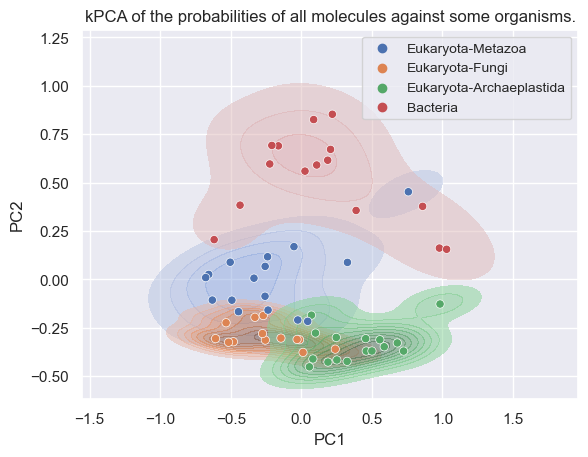

In [10]:
sns.kdeplot(x="PC1", y="PC2", data=pca_df, hue="Kingdom", fill=True, alpha=0.5)
sns.scatterplot(data=pca_df, x=pca_df['PC1'], y=pca_df['PC2'], hue='Kingdom')
plt.legend(fontsize="small")
plt.title("kPCA of the probabilities of all molecules against some organisms.")

In [11]:
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

# Assuming that 'Kingdom' is your group variable
manova = MANOVA.from_formula('PC1 + PC2 ~ Kingdom', data=pca_df)
print(manova.mv_test().summary())

                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.2471 2.0000 55.0000 83.8038 0.0000
          Pillai's trace 0.7529 2.0000 55.0000 83.8038 0.0000
  Hotelling-Lawley trace 3.0474 2.0000 55.0000 83.8038 0.0000
     Roy's greatest root 3.0474 2.0000 55.0000 83.8038 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
        Kingdom         Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.1012 6.0000 110.0000 39.2926 0.0000
         Pillai's trace 1.2127 6.0000 112.0000 28.7505 0.0000
 Hotelling-Lawley trace 5.

In [12]:
pca_df.reset_index(inplace=True, drop=True)

In [13]:
# Get the means for each group
pca_df[['PC1', 'PC2', 'Kingdom']].groupby(['Kingdom']).median()

,PC1,PC2
Kingdom,,
Bacteria,0.109152,0.590994
Eukaryota-Archaeplastida,0.390343,-0.359013
Eukaryota-Fungi,-0.269529,-0.310321
Eukaryota-Metazoa,-0.256541,0.007731


/usr/local/Caskroom/mambaforge/base/envs/stellargraph/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x500 with 0 Axes>

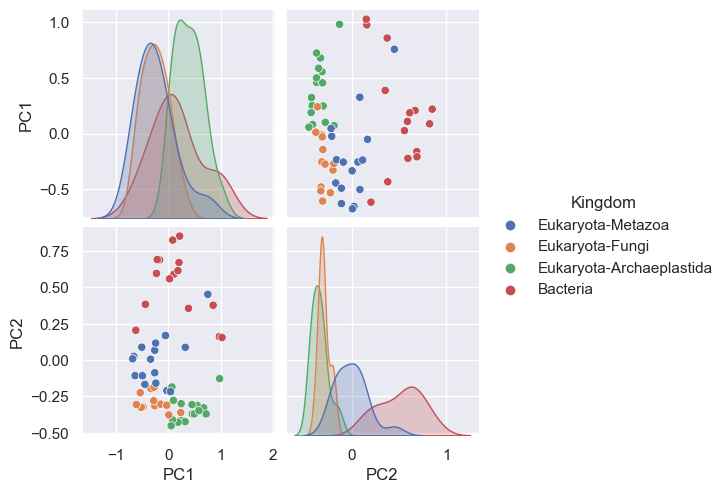

In [14]:
plt.figure(figsize=(10, 5))
sns.pairplot(pca_df, hue='Kingdom', vars=['PC1', 'PC2'])

<Axes: xlabel='Kingdom', ylabel='PC1'>

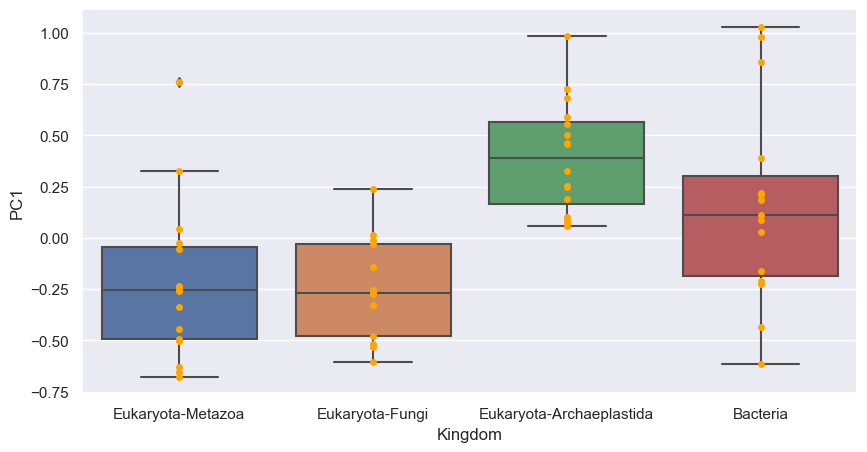

In [15]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=pca_df, x='Kingdom', y='PC1')
sns.stripplot(data=pca_df, x='Kingdom', y="PC1", color="orange", jitter=0)

<Axes: xlabel='Kingdom', ylabel='PC2'>

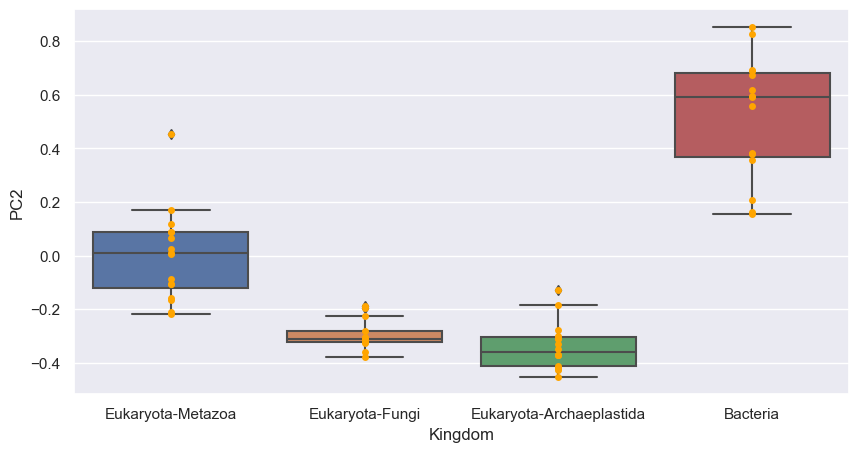

In [16]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=pca_df, x='Kingdom', y='PC2')
sns.stripplot(data=pca_df, x='Kingdom', y="PC2", color="orange", jitter=0)

In [17]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Run Tukey's test for PC1
tukey_pc1 = pairwise_tukeyhsd(endog=pca_df['PC1'], groups=pca_df['Kingdom'], alpha=0.005)
print(tukey_pc1)

                  Multiple Comparison of Means - Tukey HSD, FWER=0.01                   
         group1                   group2          meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------
                Bacteria Eukaryota-Archaeplastida    0.229 0.3066 -0.2278  0.6859  False
                Bacteria          Eukaryota-Fungi  -0.4091 0.0221 -0.8908  0.0726  False
                Bacteria        Eukaryota-Metazoa  -0.3926 0.0201 -0.8495  0.0642  False
Eukaryota-Archaeplastida          Eukaryota-Fungi  -0.6381 0.0001 -1.1127 -0.1635   True
Eukaryota-Archaeplastida        Eukaryota-Metazoa  -0.6216 0.0001 -1.0711 -0.1722   True
         Eukaryota-Fungi        Eukaryota-Metazoa   0.0165 0.9994 -0.4582  0.4911  False
----------------------------------------------------------------------------------------


In [18]:
# Run Tukey's test for PC2
tukey_pc2 = pairwise_tukeyhsd(endog=pca_df['PC2'], groups=pca_df['Kingdom'], alpha=0.005)
print(tukey_pc2)

                  Multiple Comparison of Means - Tukey HSD, FWER=0.01                   
         group1                   group2          meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------
                Bacteria Eukaryota-Archaeplastida  -0.8548    0.0 -1.0488 -0.6608   True
                Bacteria          Eukaryota-Fungi  -0.8093    0.0 -1.0139 -0.6048   True
                Bacteria        Eukaryota-Metazoa  -0.5175    0.0 -0.7115 -0.3235   True
Eukaryota-Archaeplastida          Eukaryota-Fungi   0.0455 0.8593 -0.1561   0.247  False
Eukaryota-Archaeplastida        Eukaryota-Metazoa   0.3372    0.0  0.1464  0.5281   True
         Eukaryota-Fungi        Eukaryota-Metazoa   0.2918    0.0  0.0902  0.4933   True
----------------------------------------------------------------------------------------


In [19]:
lotus.columns

Index(['structure_wikidata', 'structure_inchikey', 'structure_inchi',
       'structure_smiles', 'structure_molecular_formula',
       'structure_exact_mass', 'structure_xlogp', 'molecule', 'structure_cid',
       'structure_nameIupac', 'structure_nameTraditional',
       'structure_stereocenters_total', 'structure_stereocenters_unspecified',
       'structure_taxonomy_npclassifier_01pathway',
       'structure_taxonomy_npclassifier_02superclass',
       'structure_taxonomy_npclassifier_03class',
       'structure_taxonomy_classyfire_chemontid',
       'structure_taxonomy_classyfire_01kingdom',
       'structure_taxonomy_classyfire_02superclass',
       'structure_taxonomy_classyfire_03class',
       'structure_taxonomy_classyfire_04directparent', 'organism_wikidata',
       'species', 'organism_taxonomy_gbifid', 'organism_taxonomy_ncbiid',
       'organism_taxonomy_ottid', 'organism_taxonomy_01domain',
       'organism_taxonomy_02kingdom', 'organism_taxonomy_03phylum',
       'organis